In [3]:
%pip install pexpect
%pip install sentence-transformers

import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
print("Modelo carregado com sucesso!")

Modelo carregado com sucesso!


In [ ]:
import pandas as pd
import os

os.system("gdown 12H957uf6mK-1X_ztT9hgFS1slpN2j-Wh")
os.system("gdown 1-QXkqH8HzLcV2JCA4Nm9G5rQhorYKJVe")

path_dict = "leandl_oesnpg_dicionario.parquet"
path_data = "leandl_oesnpg_dados.parquet"

dicionario_df = pd.read_parquet(path_dict, engine='fastparquet')
df = pd.read_parquet(path_data, engine='fastparquet')

print(f"Dimensões do dicionário: {dicionario_df.shape}")
print(f"Dimensões dos dados: {df.shape}")

Downloading...
From: https://drive.google.com/uc?id=12H957uf6mK-1X_ztT9hgFS1slpN2j-Wh
To: /srv/gmelo/marcacini/Lean2-Gabriel/leandl_oesnpg_dicionario.parquet
100%|██████████| 4.24k/4.24k [00:00<00:00, 11.5MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1-QXkqH8HzLcV2JCA4Nm9G5rQhorYKJVe
From (redirected): https://drive.google.com/uc?id=1-QXkqH8HzLcV2JCA4Nm9G5rQhorYKJVe&confirm=t&uuid=5d3c19d4-f22a-4169-8799-4987a31f8638
To: /srv/gmelo/marcacini/Lean2-Gabriel/leandl_oesnpg_dados.parquet
  0%|          | 0.00/123M [00:00<?, ?B/s]Downloading...
From (original): https://drive.google.com/uc?id=1-QXkqH8HzLcV2JCA4Nm9G5rQhorYKJVe
From (redirected): https://drive.google.com/uc?id=1-QXkqH8HzLcV2JCA4Nm9G5rQhorYKJVe&confirm=t&uuid=5d3c19d4-f22a-4169-8799-4987a31f8638
To: /srv/gmelo/marcacini/Lean2-Gabriel/leandl_oesnpg_dados.parquet
100%|██████████| 123M/123M [00:01<00:00, 64.4MB/s] 
100%|██████████| 123M/123M [00:01<00:00, 64.4MB/s]


Dimensões do dicionário: (25, 2)
Dimensões dos dados: (42046, 25)


In [ ]:
trabalhos_textos = []
for _, row in df.iterrows():
    titulo = str(row.get('nome_producao', ''))
    resumo = str(row.get('descricao_resumo', ''))
    texto_completo = f"{titulo} {resumo}".strip()
    trabalhos_textos.append(texto_completo)

print(f"Total de trabalhos: {len(trabalhos_textos)}") 

temas_unicos = df['tema'].unique()
print(f"Total de temas únicos: {len(temas_unicos)}")

print("\nPrimeiros 5 temas:")
for i, tema in enumerate(temas_unicos[:5]):
    print(f"{i+1}. {tema[:80]}...") 

Total de trabalhos: 42046
Total de temas únicos: 438

Primeiros 5 temas:
1. Agronegócio e Tecnologias de Informação e Comunicação...
2. Biodiversidade e Biotecnologia...
3. Bioeconomia: cadeias produtivas prioritárias, produtos e serviços...
4. Desenvolvimento Regional da Tríplice Divisa Amazonas-Acre-Rondônia...
5. Desenvolvimento Regional: integração Estado-Município...


In [ ]:
temas_embeddings = model.encode(
    temas_unicos.tolist(), 
    show_progress_bar=True,
    batch_size=32,
    convert_to_tensor=False
)

print(temas_embeddings.shape)

Batches: 100%|██████████| 14/14 [00:00<00:00, 62.23it/s]

(438, 384)


In [ ]:
trabalhos_embeddings = model.encode(
    trabalhos_textos, 
    show_progress_bar=True,
    batch_size=32,
    convert_to_tensor=False
)

print(trabalhos_embeddings.shape)

Batches: 100%|██████████| 1314/1314 [00:26<00:00, 48.81it/s]



(42046, 384)


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(trabalhos_embeddings, temas_embeddings)

print(f"Matriz de similaridade: {similarity_matrix.shape}")
print(f"Cada trabalho foi comparado com {len(temas_unicos)} temas")

Matriz de similaridade: (42046, 438)
Cada trabalho foi comparado com 438 temas


In [ ]:
import numpy as np
best_theme_indices = np.argmax(similarity_matrix, axis=1)

best_similarities = np.max(similarity_matrix, axis=1)

results_df = pd.DataFrame({
    'tese_index': range(len(df)),
    'melhor_tema_index': best_theme_indices,
    'melhor_tema': [temas_unicos[i] for i in best_theme_indices],
    'similaridade_maxima': best_similarities,
    'tema_original': df['tema'].values,
    'nome_producao': df['nome_producao'].values
})

print(f"Resultados processados para {len(results_df)} teses")

Resultados processados para 42046 teses


In [ ]:
#Classificar similaridades em ALTO, MÉDIO, BAIXO
def classificar_aderencia(similaridade):
    if similaridade >= 0.75:  
        return 'ALTO'
    elif similaridade >= 0.60:  
        return 'MÉDIO'
    else:
        return 'BAIXO'

results_df['nivel_aderencia'] = results_df['similaridade_maxima'].apply(classificar_aderencia)

results_df['tema_correto'] = results_df['tema_original'] == results_df['melhor_tema']

print("Classificação concluída!")

print(f"\nDISTRIBUIÇÃO DOS NÍVEIS DE ADERÊNCIA:")
print(results_df['nivel_aderencia'].value_counts())

print(f"\nACURÁCIA DO MAPEAMENTO:")
acuracia = results_df['tema_correto'].mean()
print(f"Temas corretos: {results_df['tema_correto'].sum()}/{len(results_df)} ({acuracia:.2%})")

print(f"\nESTATÍSTICAS DE SIMILARIDADE:")
print(f"Média: {results_df['similaridade_maxima'].mean():.4f}")
print(f"Mediana: {results_df['similaridade_maxima'].median():.4f}")
print(f"Máximo: {results_df['similaridade_maxima'].max():.4f}")
print(f"Mínimo: {results_df['similaridade_maxima'].min():.4f}")

Classificação concluída!

DISTRIBUIÇÃO DOS NÍVEIS DE ADERÊNCIA:
nivel_aderencia
MÉDIO    25944
BAIXO    14841
ALTO      1261
Name: count, dtype: int64

ACURÁCIA DO MAPEAMENTO:
Temas corretos: 2466/42046 (5.87%)

ESTATÍSTICAS DE SIMILARIDADE:
Média: 0.6254
Mediana: 0.6260
Máximo: 0.8683
Mínimo: 0.3838


In [ ]:
# PASSO 8: Análise detalhada dos resultados
print("TOP 5 - ALTA ADERÊNCIA:")
alta_aderencia = results_df[results_df['nivel_aderencia'] == 'ALTO'].nlargest(5, 'similaridade_maxima')
for _, row in alta_aderencia.iterrows():
    print(f"Similaridade: {row['similaridade_maxima']:.4f}")
    print(f"Tema encontrado: {row['melhor_tema'][:60]}...")
    print(f"Tese: {row['nome_producao'][:80]}...")
    print(f"Correto: {'✅' if row['tema_correto'] else '❌'}\n")

print("TOP 5 - MÉDIA ADERÊNCIA:")
media_aderencia = results_df[results_df['nivel_aderencia'] == 'MÉDIO'].nlargest(5, 'similaridade_maxima')
for _, row in media_aderencia.iterrows():
    print(f"Similaridade: {row['similaridade_maxima']:.4f}")
    print(f"Tema encontrado: {row['melhor_tema'][:60]}...")
    print(f"Tese: {row['nome_producao'][:80]}...")
    print(f"Correto: {'✅' if row['tema_correto'] else '❌'}\n")

print("TOP 5 - BAIXA ADERÊNCIA:")
baixa_aderencia = results_df[results_df['nivel_aderencia'] == 'BAIXO'].nlargest(5, 'similaridade_maxima')
for _, row in baixa_aderencia.iterrows():
    print(f"Similaridade: {row['similaridade_maxima']:.4f}")
    print(f"Tema encontrado: {row['melhor_tema'][:60]}...")
    print(f"Tese: {row['nome_producao'][:80]}...")
    print(f"Correto: {'✅' if row['tema_correto'] else '❌'}\n")

TOP 5 - ALTA ADERÊNCIA:
Similaridade: 0.8683
Tema encontrado: Violência contra Mulher...
Tese: ABORDAGEM INTERSETORIAL E INTEGRADA A MULHERES EM SITUAÇÃO DE VIOLÊNCIA DOMÉSTIC...
Correto: ❌

Similaridade: 0.8683
Tema encontrado: Violência contra Mulher...
Tese: ABORDAGEM INTERSETORIAL E INTEGRADA A MULHERES EM SITUAÇÃO DE VIOLÊNCIA DOMÉSTIC...
Correto: ❌

Similaridade: 0.8658
Tema encontrado: Violência contra Mulher...
Tese: REDE DE ENFRENTAMENTO À VIOLÊNCIA CONTRA A MULHER: REPRESENTAÇÕES SOCIAIS DA EQU...
Correto: ❌

Similaridade: 0.8658
Tema encontrado: Violência contra Mulher...
Tese: REDE DE ENFRENTAMENTO À VIOLÊNCIA CONTRA A MULHER: REPRESENTAÇÕES SOCIAIS DA EQU...
Correto: ❌

Similaridade: 0.8608
Tema encontrado: Violência contra Mulher...
Tese: VIOLÊNCIA CONTRA A MULHER INDÍGENA: UMA ANÁLISE MULTINÍVEL SOBRE A OCORRÊNCIA NA...
Correto: ❌

TOP 5 - MÉDIA ADERÊNCIA:
Similaridade: 0.7000
Tema encontrado: Biotecnologia para o Semiárido...
Tese: AÇÃO DA APLICAÇÃO DE BIODEFENSIVOS MIC

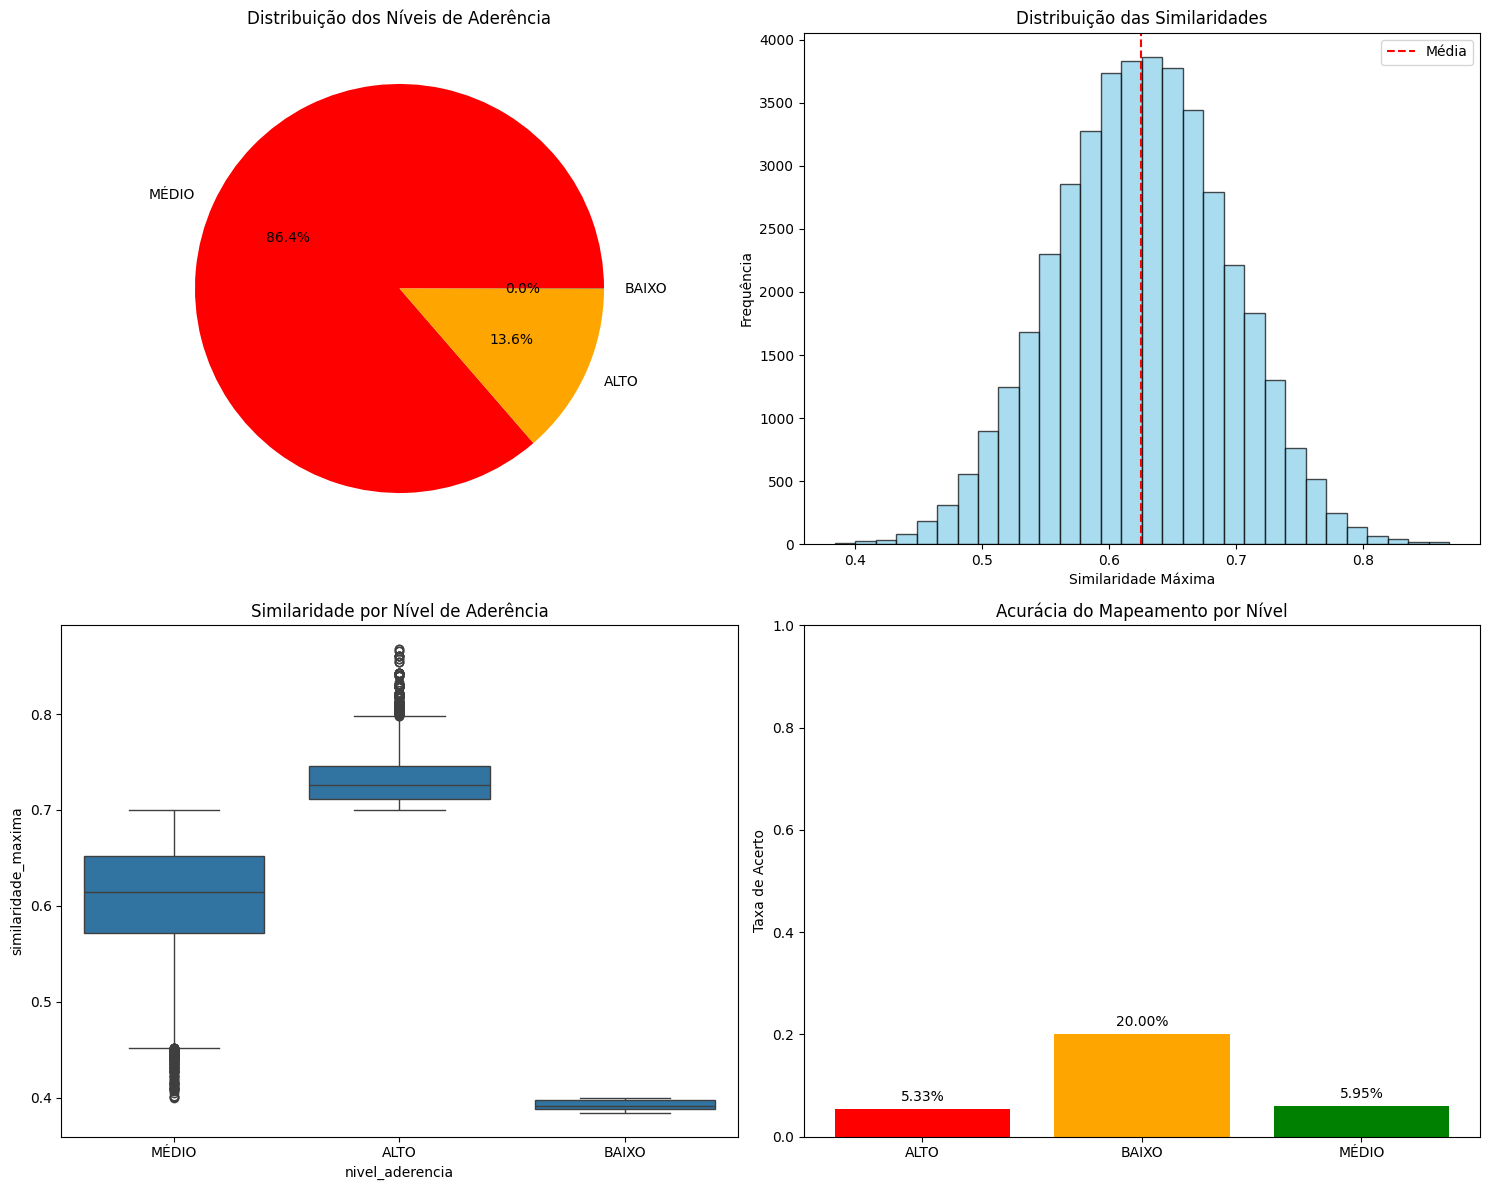

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

ax1 = axes[0, 0]
nivel_counts = results_df['nivel_aderencia'].value_counts()
colors = ['red', 'orange', 'green']
ax1.pie(nivel_counts.values, labels=nivel_counts.index, autopct='%1.1f%%', colors=colors)
ax1.set_title('Distribuição dos Níveis de Aderência')

ax2 = axes[0, 1]
ax2.hist(results_df['similaridade_maxima'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
ax2.set_xlabel('Similaridade Máxima')
ax2.set_ylabel('Frequência')
ax2.set_title('Distribuição das Similaridades')
ax2.axvline(results_df['similaridade_maxima'].mean(), color='red', linestyle='--', label='Média')
ax2.legend()

ax3 = axes[1, 0]
sns.boxplot(data=results_df, x='nivel_aderencia', y='similaridade_maxima', ax=ax3)
ax3.set_title('Similaridade por Nível de Aderência')

ax4 = axes[1, 1]
acuracia_por_nivel = results_df.groupby('nivel_aderencia')['tema_correto'].mean()
bars = ax4.bar(acuracia_por_nivel.index, acuracia_por_nivel.values, color=['red', 'orange', 'green'])
ax4.set_ylabel('Taxa de Acerto')
ax4.set_title('Acurácia do Mapeamento por Nível')
ax4.set_ylim(0, 1)

for bar, value in zip(bars, acuracia_por_nivel.values):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.2%}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
# PASSO 10: Salvar resultados
print("Salvando resultados...")

results_df.to_csv('resultados_mapeamento_temas.csv', index=False, encoding='utf-8')

with open('resumo_analise.txt', 'w', encoding='utf-8') as f:
    f.write("=== RESUMO DA ANÁLISE DE MAPEAMENTO DE TEMAS ===\n\n")
    f.write(f"Total de teses analisadas: {len(results_df)}\n")
    f.write(f"Total de temas únicos: {len(temas_unicos)}\n\n")
    
    f.write("DISTRIBUIÇÃO DOS NÍVEIS:\n")
    for nivel, count in results_df['nivel_aderencia'].value_counts().items():
        pct = count / len(results_df) * 100
        f.write(f"  {nivel}: {count} ({pct:.1f}%)\n")
    
    f.write(f"\nACURÁCIA GERAL: {acuracia:.2%}\n")
    
    f.write(f"\nESTATÍSTICAS DE SIMILARIDADE:\n")
    f.write(f"  Média: {results_df['similaridade_maxima'].mean():.4f}\n")
    f.write(f"  Mediana: {results_df['similaridade_maxima'].median():.4f}\n")
    f.write(f"  Desvio padrão: {results_df['similaridade_maxima'].std():.4f}\n")

print("Resultados salvos em:")
print("  - resultados_mapeamento_temas.csv")
print("  - resumo_analise.txt")

print("ANÁLISE COMPLETA!")